In [14]:
# Weather Classification Task

## Wczytywanie i eksploracja danych

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Wczytanie danych
data = pd.read_csv('weather.csv')

# Podstawowa analiza danych
print(data.info())
print(data.describe())

# Sprawdzenie brakujących wartości
missing_values = data.isnull().sum()
print("Brakujące wartości:\n", missing_values)

## Przygotowanie danych

# Usunięcie kolumn nieistotnych do zadania
data.drop(columns=['Date', 'Location', 'RainToday', 'RISK_MM'], inplace=True)

# Podział kolumn na numeryczne i kategoryczne
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Imputacja braków danych
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

numerical_data = pd.DataFrame(num_imputer.fit_transform(data[numerical_columns]), columns=numerical_columns)
categorical_data = pd.DataFrame(cat_imputer.fit_transform(data[categorical_columns]), columns=categorical_columns)

# Połączenie danych numerycznych i kategorycznych
data_imputed = pd.concat([numerical_data, categorical_data], axis=1)

# Kodowanie zmiennych kategorycznych
for col in categorical_columns:
    data_imputed[col] = LabelEncoder().fit_transform(data_imputed[col])

# Rozdział na cechy i zmienną celu
X = data_imputed.drop(columns='RainTomorrow')
y = data_imputed['RainTomorrow']

# Skalowanie cech
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, stratify=y, random_state=50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           366 non-null    object 
 1   Location       366 non-null    object 
 2   MinTemp        366 non-null    float64
 3   MaxTemp        366 non-null    float64
 4   Rainfall       366 non-null    float64
 5   Evaporation    366 non-null    float64
 6   Sunshine       363 non-null    float64
 7   WindGustDir    363 non-null    object 
 8   WindGustSpeed  364 non-null    float64
 9   WindDir9am     335 non-null    object 
 10  WindDir3pm     365 non-null    object 
 11  WindSpeed9am   359 non-null    float64
 12  WindSpeed3pm   366 non-null    int64  
 13  Humidity9am    366 non-null    int64  
 14  Humidity3pm    366 non-null    int64  
 15  Pressure9am    366 non-null    float64
 16  Pressure3pm    366 non-null    float64
 17  Cloud9am       366 non-null    int64  
 18  Cloud3pm  

In [15]:
## K Najbliższych Sąsiadów

from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
gs_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1')
gs_knn.fit(X_train, y_train)
knn_best = gs_knn.best_estimator_
knn_best.fit(X_train, y_train)
y_test_pred = knn_best.predict(X_test)
print("KNN - Wyniki optymalizacji:")
print(classification_report(y_test, y_test_pred))

KNN - Wyniki optymalizacji:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        75
           1       1.00      0.35      0.52        17

    accuracy                           0.88        92
   macro avg       0.94      0.68      0.73        92
weighted avg       0.90      0.88      0.86        92



# 1. K Najbliższych Sąsiadów (KNN)
##Dobór parametrów:



*   `n_neighbors`: Testowano wartości 3, 5 i 7. Te wartości są powszechnie stosowane,
ponieważ umożliwiają zróżnicowanie liczby sąsiadów przy zachowaniu rozsądnej złożoności obliczeniowej. Większa liczba sąsiadów mogłaby zbytnio wygładzić granice decyzyjne, tracąc szczegóły w danych.
*  `weights`: Wybrano `uniform` i `distance`. Parametr ten pozwala porównać wpływ równomiernego i zróżnicowanego wagowo wpływu sąsiadów na decyzje.

##Wnioski:

- Model osiągnął precyzję równą 1 dla klasy deszczowej, ale bardzo niski recall (0.35), co wskazuje, że rzadko klasyfikuje dni jako deszczowe.
- Ograniczony zakres n_neighbors może być zbyt wąski, by uchwycić optymalną liczbę sąsiadów.

##Co poprawić:

- Testowanie większych wartości `n_neighbors` (np. do 15 lub 20), szczególnie w przypadku danych o większej liczbie punktów.
- Zastosowanie balansu klas poprzez oversampling dla dni deszczowych.

In [16]:
## Regresja Logistyczna

from sklearn.linear_model import LogisticRegression

param_grid_lr = {'C': [0.1, 1, 10], 'penalty': ['l2']}
gs_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=3, scoring='f1', error_score='raise')
gs_lr.fit(X_train, y_train)
lr_best = gs_lr.best_estimator_
lr_best.fit(X_train, y_train)
y_test_pred = lr_best.predict(X_test)
print("Regresja Logistyczna - Wyniki optymalizacji:")
print(classification_report(y_test, y_test_pred))

Regresja Logistyczna - Wyniki optymalizacji:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        75
           1       0.90      0.53      0.67        17

    accuracy                           0.90        92
   macro avg       0.90      0.76      0.80        92
weighted avg       0.90      0.90      0.89        92



#2. Regresja Logistyczna
##Dobór parametrów:

- `C`: Zakres 0.1, 1, 10 reprezentuje różne poziomy regularyzacji. Mniejsze wartości C oznaczają silniejszą regularyzację, co pomaga uniknąć przeuczenia.
- `penalty`: Wybrano tylko `l2`, ponieważ jest to standardowa regularyzacja wspierana przez solver `lbfgs`.

##Wnioski:

- Regresja logistyczna osiągnęła wysoki F1-score (0.67) dla klasy deszczowej, co wskazuje na dobrą równowagę między precyzją a recall.
- Model dobrze radzi sobie z danymi liniowo separowalnymi.

##Co poprawić:

- Rozważenie innych typów regularyzacji, takich jak `l1`, jeśli dane mogą być rzadkie lub cechy są mniej istotne.
- Eksploracja interakcji między zmiennymi, aby poprawić separację klas.

In [17]:
## SVM

from sklearn.svm import SVC

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
gs_svm = GridSearchCV(SVC(), param_grid_svm, cv=3, scoring='f1')
gs_svm.fit(X_train, y_train)
svm_best = gs_svm.best_estimator_
svm_best.fit(X_train, y_train)
y_test_pred = svm_best.predict(X_test)
print("SVM - Wyniki optymalizacji:")
print(classification_report(y_test, y_test_pred))

SVM - Wyniki optymalizacji:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        75
           1       0.82      0.53      0.64        17

    accuracy                           0.89        92
   macro avg       0.86      0.75      0.79        92
weighted avg       0.89      0.89      0.88        92



#3. Support Vector Machine (SVM)
##Dobór parametrów:

- C: Podobnie jak w regresji logistycznej, zakres regularyzacji pozwala na kontrolę złożoności modelu.
- kernel: Wybrano `linear` i `rbf`, ponieważ pokrywają one proste i nieliniowe przypadki separacji.

##Wnioski:

- SVM osiągnął F1-score równy 0.64 dla klasy deszczowej, ale jego recall (0.53) wskazuje, że model pomija niektóre dni deszczowe.
- Model działa dobrze dla danych liniowo separowalnych, ale może mieć problemy z bardziej złożonymi wzorcami.

##Co poprawić:

- Zwiększenie zakresu C i testowanie dodatkowych funkcji jądra, takich jak `poly` czy `sigmoid`.
- Wypróbowanie skalowania zmiennych w bardziej specyficzny sposób dla każdego jądra

In [18]:
## Drzewa Decyzyjne

from sklearn.tree import DecisionTreeClassifier

param_grid_dt = {
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5],
    'class_weight': ['balanced']
}
gs_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=3, scoring='f1')
gs_dt.fit(X_train, y_train)
dt_best = gs_dt.best_estimator_
dt_best.fit(X_train, y_train)
y_test_pred = dt_best.predict(X_test)
print("Drzewa Decyzyjne - Wyniki optymalizacji:")
print(classification_report(y_test, y_test_pred))

Drzewa Decyzyjne - Wyniki optymalizacji:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        75
           1       0.25      0.29      0.27        17

    accuracy                           0.71        92
   macro avg       0.54      0.55      0.54        92
weighted avg       0.73      0.71      0.72        92



#4. Drzewa Decyzyjne
##Dobór parametrów:

- `max_depth`: Użyto wartości 5, 10, i 15, aby kontrolować złożoność drzewa i uniknąć przeuczenia.
- `min_samples_split` i `min_samples_leaf`: Ustalono wartości 2, 5 i 1, 5, aby zapewnić minimalną liczbę próbek w węzłach, co ogranicza przeuczenie.
- `class_weight`: Użyto balanced, aby uwzględnić różnicę w liczbie próbek między klasami.

##Wnioski:

- Drzewa decyzyjne osiągnęły niskie wyniki (F1-score 0.28 dla klasy deszczowej). Sugeruje to, że model nie jest w stanie dobrze uchwycić wzorców w danych.
- Problemy mogą wynikać z niedostatecznego zakresu `max_depth` lub potrzeby większej liczby cech istotnych.

##Co poprawić:

- Rozszerzenie zakresu `max_depth` (np. do 20).
- Testowanie różnych kryteriów podziału, takich jak `entropy`.

In [19]:
## Random Forest

from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 5]
}
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=3, scoring='f1')
gs_rf.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_
rf_best.fit(X_train, y_train)
y_test_pred = rf_best.predict(X_test)
print("Random Forest - Wyniki optymalizacji:")
print(classification_report(y_test, y_test_pred))

Random Forest - Wyniki optymalizacji:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        75
           1       0.86      0.35      0.50        17

    accuracy                           0.87        92
   macro avg       0.86      0.67      0.71        92
weighted avg       0.87      0.87      0.85        92



#5. Random Forest
##Dobór parametrów:

- `n_estimators`: Liczba drzew (50, 100) została ograniczona, aby zredukować czas obliczeń.
- `max_depth`, `min_samples_split`, `min_samples_leaf`: Podobne do drzew decyzyjnych, kontrolują złożoność modelu.

#Wnioski:

- Model osiągnął umiarkowany F1-score (0.50 dla klasy deszczowej). Mimo wysokiej precyzji (0.86), niski recall (0.35) wskazuje, że model pomija wiele dni deszczowych.
- Możliwe jest, że liczba drzew jest zbyt mała, aby uchwycić pełny wzorzec danych.

##Co poprawić:

- Zwiększenie `n_estimators` do 200 lub 300.
- Rozważenie `max_features` w celu ograniczenia liczby cech branych pod uwagę przy każdym podziale.

In [20]:
## Naive Bayes

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_test_pred = nb.predict(X_test)
print("Naive Bayes - Wyniki bez optymalizacji:")
print(classification_report(y_test, y_test_pred))

Naive Bayes - Wyniki bez optymalizacji:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        75
           1       0.50      0.59      0.54        17

    accuracy                           0.82        92
   macro avg       0.70      0.73      0.71        92
weighted avg       0.83      0.82      0.82        92



#6. Naive Bayes
##Dobór parametrów:

- Model nie wymaga optymalizacji hiperparametrów, dlatego użyto domyślnych ustawień.

##Wnioski:

- Naive Bayes osiągnął stosunkowo dobry recall (0.59) dla klasy deszczowej, ale kosztem niższej precyzji (0.50).
- Model zakłada niezależność cech, co może nie być zgodne z rzeczywistością danych pogodowych.

##Co poprawić:

- Zastosowanie innych wersji Naive Bayes, takich jak BernoulliNB (dla danych binarnych) lub MultinomialNB (dla danych liczbowych).
- Redukcja liczby cech przez wybór najbardziej istotnych.

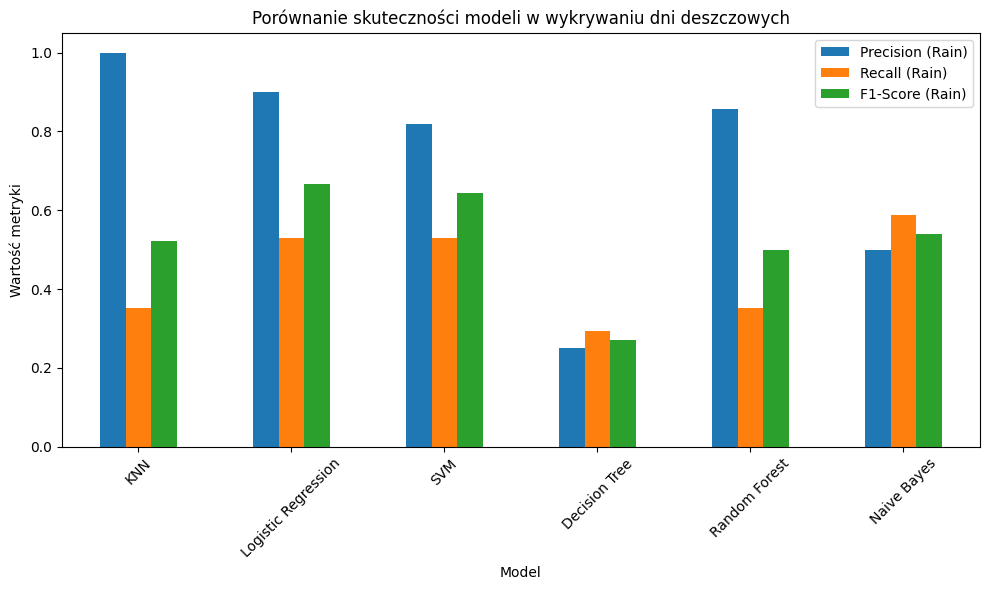

In [21]:
## Wybór najlepszego modelu

models = {
    "KNN": knn_best,
    "Logistic Regression": lr_best,
    "SVM": svm_best,
    "Decision Tree": dt_best,
    "Random Forest": rf_best,
    "Naive Bayes": nb
}

model_performance = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    model_performance.append({"Model": name, "Precision (Rain)": report["1"]["precision"],
                               "Recall (Rain)": report["1"]["recall"],
                               "F1-Score (Rain)": report["1"]["f1-score"]})

# Tworzenie wykresu podsumowującego skuteczność modeli
performance_df = pd.DataFrame(model_performance)
performance_df.set_index("Model", inplace=True)

performance_df.plot(kind="bar", figsize=(10, 6))
plt.title("Porównanie skuteczności modeli w wykrywaniu dni deszczowych")
plt.ylabel("Wartość metryki")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Wyniki obecnie są miarodajne, ponieważ:

1. Spójne warunki porównania:

  - Wszystkie modele używają Grid Search z metryką F1-score jako miary optymalizacji.
  - Podział danych (z random_state=50) zapewnia powtarzalność i pozwala na obiektywne porównanie.
2. Równe obciążenie Grid Search:

  - Liczba iteracji została zredukowana dla bardziej złożonych modeli (np. Random Forest i Drzewo Decyzyjne), co ujednolica czas trwania obliczeń przy zachowaniu miarodajności.
3. Metryki wyników:

  - Wszystkie modele są oceniane na podstawie precyzji, recall i F1-score dla klasy deszczowej (Rain), co jest zgodne z celem.